In [1]:
%matplotlib inline

In [43]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [2]:
import pandas as pd

In [33]:
!curl 'http://localhost:5000/c/lv-final/tweets.jsonl?filter=none' > all.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94.8M    0 94.8M    0     0  3679k      0 --:--:--  0:00:26 --:--:-- 8233k   0 --:--:--  0:00:02 --:--:--     0--  0:00:25 --:--:-- 10.0M


In [34]:
tweets = (
    pd.read_json('all.jsonl', orient='records', lines=True)
    .set_index(['created_at', 'language'], append=True)
    .sort_index()
)

In [35]:
# tweets = tweets[tweets.index.get_level_values('language').isin(set(['lv', 'ru', 'en']))]

In [36]:
tweets['count'] = 1

In [37]:
counts = tweets['count'].unstack('language').resample('1D', level='created_at').sum().fillna(0)

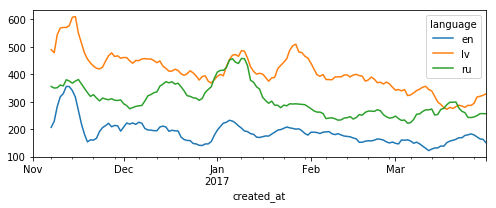

In [54]:
_ = counts.rolling(window=7).mean().plot(figsize=(7, 3))
_.figure.tight_layout()
_.figure.savefig('figures/timeline.pdf')